In [5]:
cd /sfs/fs6/home-geomar/smomw184/_ANA/ORCA025.L46/coarse_graining/temperature_drift

/sfs/fs1/work-geomar1/smomw184/ANA/ORCA025.L46/coarse_graining/temperature_drift


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from netCDF4 import Dataset
from haversine import haversine
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from cmocean import cm
from matplotlib import ticker
import xarray as xr
import sys
from pathlib2 import Path
import seawater as sw

NB_CM_IN_INCH = 2.54

def convert_cm_to_inch(val):
    return val / NB_CM_IN_INCH

def mean(T,grid3d_in):
    return np.nansum(np.nansum(T*grid3d_in,2),2)/np.nansum(np.nansum(grid3d_in,1),1)[None,:]

def box_mean(var1,var2,i1,i2,j1,j2):
    grid_part = grid[0:10,j1:j2,i1:i2]
    diff      = np.nansum(np.nansum(np.nansum((var2-var1)[:,:,j1:j2,i1:i2] * grid_part,1),1),1)/np.nansum(grid_part)
    diff_perc = diff / (np.nansum(np.nansum(np.nansum((var1[:,:,j1:j2,i1:i2]) * grid_part,1),1),1)\
                        /np.nansum(grid_part)) *100 # in %
    return diff, diff_perc

def area_mean(T,grid3d_in,i1,i2,j1,j2):
    return np.nansum(np.nansum(T[:,:j1:j2,i1:i2]*grid3d_in[None,:j1:j2,i1:i2],2),2)/np.nansum(np.nansum(grid3d_in,1),1)[None,:]

/gpfs/fs6/home-geomar/smomw122/TM/software/miniconda3_20180110/envs/py2_std/lib/python2.7/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [7]:
CTRL_T_data = xr.open_dataset('ORCA025.L46-KRA031_5d_19580101_20041231_grid_T_votemper_1y.nc')
CTRL_T_new      = CTRL_T_data.votemper.squeeze()

CG_T_data   = xr.open_dataset('ORCA025.L46-KRA032_5d_19580101_20041231_grid_T_votemper_1y.nc')
CG_T_new        = CG_T_data.votemper.squeeze()

In [8]:
# NaN over land
CTRL_T_new2 = CTRL_T_new.where(CTRL_T_new!= 0)
CG_T_new2   = CG_T_new.where(CG_T_new!= 0)

In [9]:
i1=850;i2=1000;j1=650;j2=740
np.nanmean(CG_T_new2[30,0,j1:j2,i1:i2]-CTRL_T_new2[30,0,j1:j2,i1:i2])

0.046492609330719935

In [10]:
maskpath = '/sfs/fs1/work-geomar1/smomw184/MASK025/'
maskdata = xr.open_dataset(maskpath +'mask.nc')
e1t=maskdata.e1t.squeeze()
e2t=maskdata.e2t.squeeze()
e3t=maskdata.e3t.squeeze()
ocean=maskdata.tmaskutil[0,:,:].squeeze()
tmask = maskdata.tmask[:,:,:,:].squeeze()

grid3d = np.array(tmask*e1t*e2t) #no e3t because no vertical integration

CTRL_t_file = '/sfs/fs6/home-geomar/smomw184/_ANA/ORCA025.L46/coarse_graining/temperature_drift/KRA031/ORCA025.L46-KRA031_5d_20040101_20041231_grid_T_votemper_1y.nc'
deptht  = np.array(xr.open_dataset(CTRL_t_file).deptht)
nav_lat=np.array(xr.open_dataset(CTRL_t_file).nav_lat)
nav_lon=np.array(xr.open_dataset(CTRL_t_file).nav_lon)

In [11]:
maskdata = xr.open_dataset(maskpath +'ORCA025.L46_new_maskglo.nc')
tmaskatl   = np.array(maskdata.tmaskatl.squeeze())
tmaskpac   = np.array(maskdata.tmaskpac.squeeze())
tmaskind   = np.array(maskdata.tmaskind.squeeze())
grid3d_atl = grid3d*tmaskatl
grid3d_pac = grid3d*tmaskpac
grid3d_ind = grid3d*tmaskind

In [12]:
# define Artic and Southern Ocean
arctic = np.array(ocean -(tmaskatl+tmaskpac+tmaskind))
arctic[0:800] = 0

SO = np.array(ocean -(tmaskatl+tmaskpac+tmaskind))
SO[300:] = 0

grid3d_arctic = grid3d*arctic[None,:,:]
grid3d_SO    = grid3d*SO[None,:,:]

In [13]:
%%time
save_drift = False
if save_drift:
    CTRL_T_glob_mean = mean(CTRL_T_new2[:,:,:,:],grid3d)
    CG_T_glob_mean = mean(CG_T_new2[:,:,:,:],grid3d)
    CTRL_T_pac_mean = mean(CTRL_T_new2[:,:,:,:],grid3d_pac)
    CG_T_pac_mean   = mean(CG_T_new2[:,:,:,:],grid3d_pac)
    CTRL_T_atl_mean = mean(CTRL_T_new2[:,:,:,:],grid3d_atl)
    CG_T_atl_mean   = mean(CG_T_new2[:,:,:,:],grid3d_atl)
    CTRL_T_ind_mean = mean(CTRL_T_new2[:,:,:,:],grid3d_ind)
    CG_T_ind_mean   = mean(CG_T_new2[:,:,:,:],grid3d_ind)
    CTRL_T_SO_mean = mean(CTRL_T_new2[:,:,:,:],grid3d_SO)
    CG_T_SO_mean   = mean(CG_T_new2[:,:,:,:],grid3d_SO)
    CTRL_T_arctic_mean = mean(CTRL_T_new2[:,:,:,:],grid3d_arctic)
    CG_T_arctic_mean   = mean(CG_T_new2[:,:,:,:],grid3d_arctic)

CPU times: user 0 ns, sys: 6 µs, total: 6 µs
Wall time: 12.2 µs


In [14]:
if save_drift:
    data=xr.Dataset({'CG_T_glob_mean': (['time','depth',],     CG_T_glob_mean),\
                     'CTRL_T_glob_mean': (['time','depth',],   CTRL_T_glob_mean),\
                     'CG_T_pac_mean': (['time','depth',],     CG_T_pac_mean),\
                     'CTRL_T_pac_mean': (['time','depth',],   CTRL_T_pac_mean),\
                     'CG_T_atl_mean': (['time','depth',],     CG_T_atl_mean),\
                     'CTRL_T_atl_mean': (['time','depth',],   CTRL_T_atl_mean),\
                     'CG_T_ind_mean': (['time','depth',],     CG_T_ind_mean),\
                     'CTRL_T_ind_mean': (['time','depth',],   CTRL_T_ind_mean),\
                     'CG_T_arctic_mean': (['time','depth',],     CG_T_arctic_mean),\
                     'CTRL_T_arctic_mean': (['time','depth',],   CTRL_T_arctic_mean),\
                     'CG_T_SO_mean': (['time','depth',],     CG_T_SO_mean),\
                     'CTRL_T_SO_mean': (['time','depth',],   CTRL_T_SO_mean)})
    T_ave = "averaged_T.nc"
    data.to_netcdf(path=T_ave)
    T_ave   = xr.open_dataset('averaged_T.nc')
else:
    T_ave   = xr.open_dataset('averaged_T.nc')

45.1069 35.1961
-24.9422 -77.5989


/gpfs/fs6/home-geomar/smomw122/TM/software/miniconda3_20180110/envs/py2_std/bin/ipython:32: RuntimeWarning: divide by zero encountered in divide


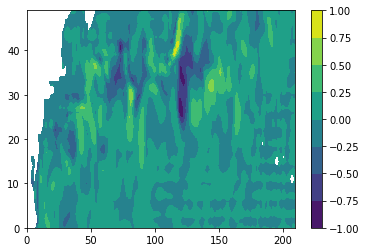

In [15]:
# GSE box
i1=840
i2=1050
j1=650
j2=700
print nav_lat[j1:j2,i1:i2].max(), nav_lat[j1:j2,i1:i2].min()
print nav_lon[j1:j2,i1:i2].max(), nav_lon[j1:j2,i1:i2].min() 
plt.contourf(CG_T_new2[0,0,j1:j2,i1:i2]-CTRL_T_new2[0,0,j1:j2,i1:i2])
plt.colorbar()

CTRL_T_new2_GS = area_mean(CTRL_T_new2,grid3d,i1,i2,j1,j2)
CG_T_new2_GS   = area_mean(CG_T_new2,grid3d,i1,i2,j1,j2)

In [16]:
def plot_drift(var):
    cs = plt.contourf(np.arange(0,47),deptht,var,levs,cmap=cm.balance,extend='both')
    plt.gca().invert_yaxis()
    plt.ylim(1000,0)
    plt.grid()
    return cs

# ORCA025 model drift

In [18]:
# m = Basemap(projection='merc',llcrnrlat=-65,urcrnrlat=65,llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')
# fig = plt.figure(figsize=(convert_cm_to_inch(30*.9), convert_cm_to_inch(14*.9)), dpi=300)
# gs = gridspec.GridSpec(210, 310)

# levs = np.linspace(-0.5,0.5,11)
#                             #a
# ax1 = plt.subplot(gs[0:90, 0:90])

# cs = plot_drift((T_ave.CTRL_T_glob_mean-T_ave.CTRL_T_glob_mean[0,:]).T)
# # plt.colorbar(cs)
#                             #b
# ax2 = plt.subplot(gs[0:90, 110:200])

# cs = plot_drift((T_ave.CTRL_T_pac_mean-T_ave.CTRL_T_pac_mean[0,:]).T)
# # plt.colorbar(cs)

#                             #c
# ax3 = plt.subplot(gs[0:90, 220:310])
# cs = plot_drift((T_ave.CTRL_T_atl_mean-T_ave.CTRL_T_atl_mean[0,:]).T)
# # plt.colorbar(cs)

#                             #d
# ax4 = plt.subplot(gs[110:200, 0:90])
# # levs = np.linspace(-0.1,0.1,11)
# cs = plot_drift((T_ave.CTRL_T_ind_mean-T_ave.CTRL_T_ind_mean[0,:]).T)
# # plt.colorbar(cs)

#                             #e
# ax5 = plt.subplot(gs[110:200, 110:200])
# # levs = np.linspace(-0.05,0.05,11)
# cs = plot_drift((T_ave.CTRL_T_arctic_mean-T_ave.CTRL_T_arctic_mean[0,:]).T)
# # plt.colorbar(cs)
     
#                             #f
# ax6 = plt.subplot(gs[110:200, 220:310])
# cs  = plot_drift((T_ave.CTRL_T_SO_mean-T_ave.CTRL_T_SO_mean[0,:]).T)
# # plt.colorbar(cs)

# cbaxes = fig.add_axes([0.35, 0.07, 0.3, 0.025])
# cb = plt.colorbar(cs,cax = cbaxes,orientation="horizontal")
# cb.ax.tick_params(labelsize=7)
# cb.ax.set_ylabel(r'[$^\circ C$]',fontsize=8,rotation=0,y=-.0,labelpad=+15)

# i=0.026
# j=0.073
# plt.text(i,j,'a) global',    ha='left',va='center',transform=ax1.transAxes,bbox={'facecolor':'white'},fontsize=8)
# plt.text(i,j,'b) Pacific',   ha='left',va='center',transform=ax2.transAxes,bbox={'facecolor':'white'},fontsize=8)
# plt.text(i,j,'c) Atlantic',  ha='left',va='center',transform=ax3.transAxes,bbox={'facecolor':'white'},fontsize=8)
# plt.text(i,j,'d) Indian',    ha='left',va='center',transform=ax4.transAxes,bbox={'facecolor':'white'},fontsize=8)
# plt.text(i,j,'e) Arctic',    ha='left',va='center',transform=ax5.transAxes,bbox={'facecolor':'white'},fontsize=8)
# plt.text(i,j,'f) Southern',  ha='left',va='center',transform=ax6.transAxes,bbox={'facecolor':'white'},fontsize=8)

# # plt.savefig('fig?_Temp_drift.png',dpi=300)

/gpfs/fs6/home-geomar/smomw122/TM/software/miniconda3_20180110/envs/py2_std/bin/ipython:8: RuntimeWarning: Mean of empty slice
/gpfs/fs6/home-geomar/smomw122/TM/software/miniconda3_20180110/envs/py2_std/bin/ipython:9: RuntimeWarning: Mean of empty slice
/gpfs/fs6/home-geomar/smomw122/TM/software/miniconda3_20180110/envs/py2_std/bin/ipython:10: RuntimeWarning: Mean of empty slice
/gpfs/fs6/home-geomar/smomw122/TM/software/miniconda3_20180110/envs/py2_std/bin/ipython:11: RuntimeWarning: Mean of empty slice
/gpfs/fs6/home-geomar/smomw122/TM/software/miniconda3_20180110/envs/py2_std/bin/ipython:12: RuntimeWarning: Mean of empty slice
/gpfs/fs6/home-geomar/smomw122/TM/software/miniconda3_20180110/envs/py2_std/bin/ipython:13: RuntimeWarning: Mean of empty slice
/gpfs/fs6/home-geomar/smomw122/TM/software/miniconda3_20180110/envs/py2_std/bin/ipython:17: RuntimeWarning: Mean of empty slice
/gpfs/fs6/home-geomar/smomw122/TM/software/miniconda3_20180110/envs/py2_std/bin/ipython:18: RuntimeWarning

('maximum in the Indian:', 0.067441584641192875)


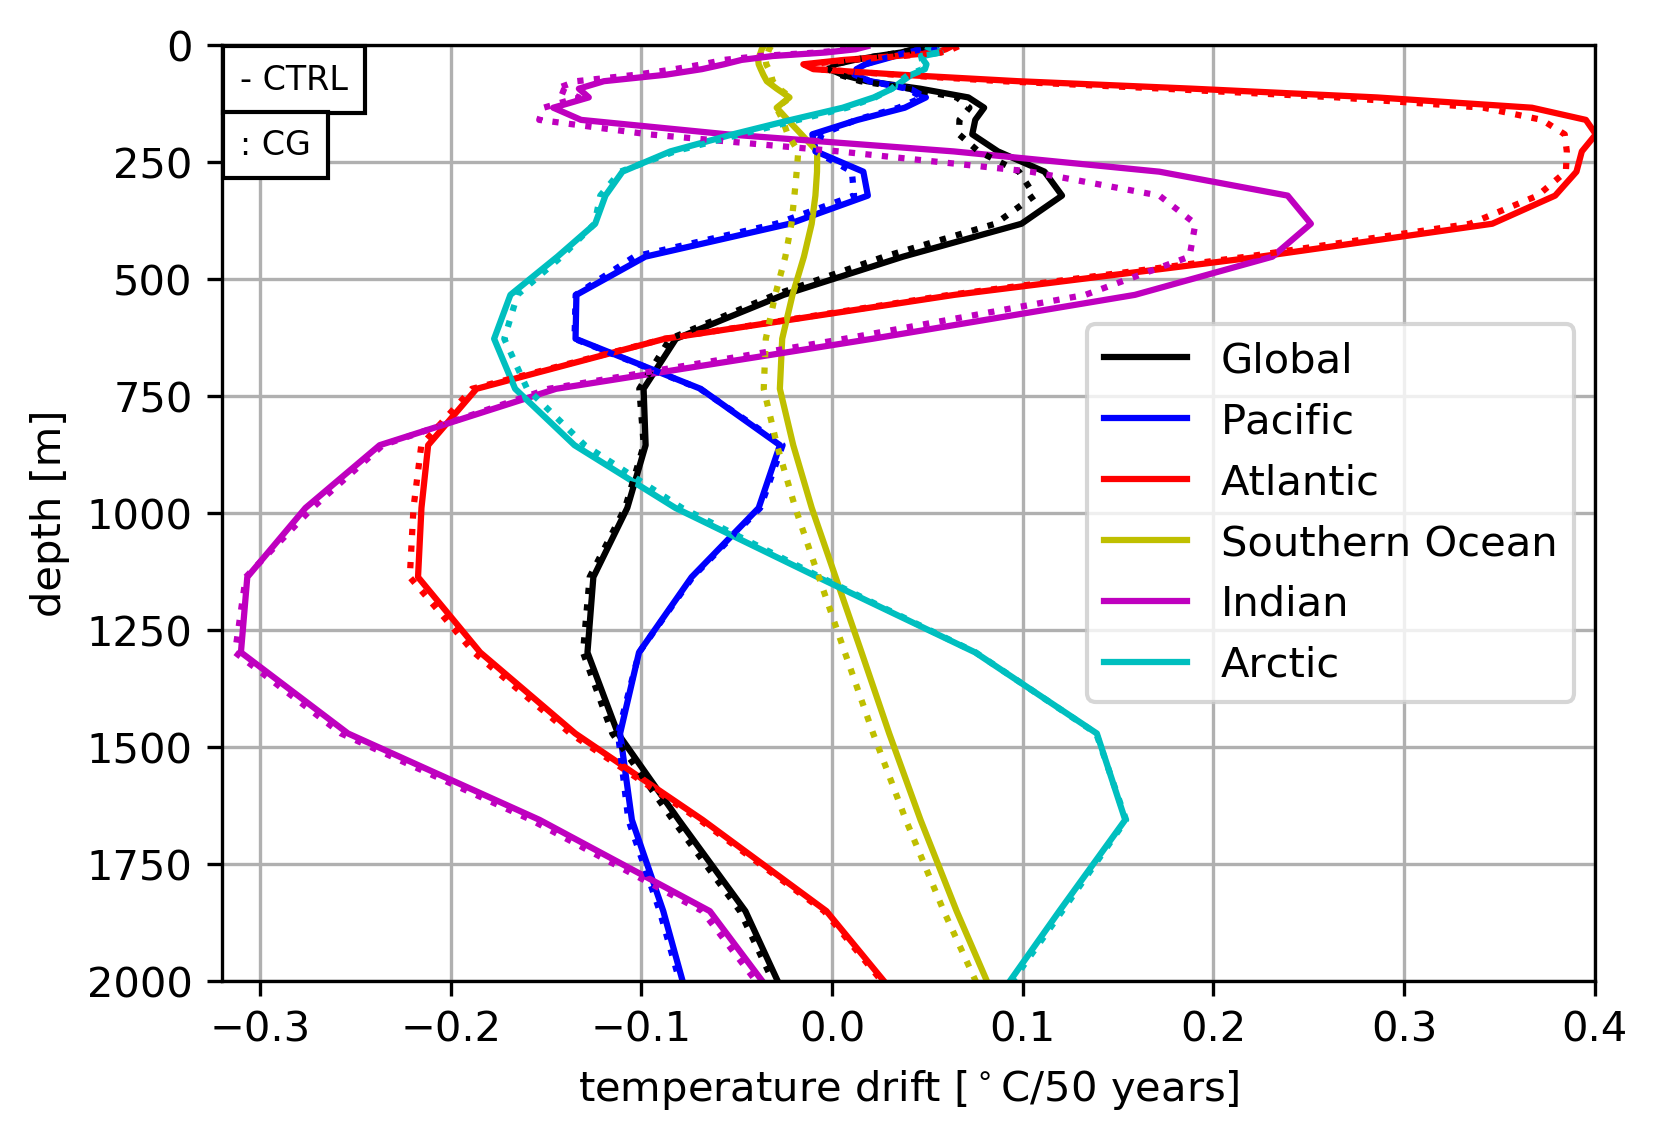

In [19]:
fig = plt.figure(figsize=(convert_cm_to_inch(15), convert_cm_to_inch(10.5)), dpi=300)
gs = gridspec.GridSpec(90, 90)

                            #a
ax1 = plt.subplot(gs[0:90, 0:90])

y = 5 # last 5 years
plt.plot(np.nanmean((T_ave.CTRL_T_glob_mean[-5:,:]   - T_ave.CTRL_T_glob_mean[0,:]),0),deptht,'k',label='Global')
plt.plot(np.nanmean((T_ave.CTRL_T_pac_mean[-5:,:]    - T_ave.CTRL_T_pac_mean[0,:]),0),deptht,'b',label='Pacific')
plt.plot(np.nanmean((T_ave.CTRL_T_atl_mean[-5:,:]    - T_ave.CTRL_T_atl_mean[0,:]),0),deptht,'r',label='Atlantic')
plt.plot(np.nanmean((T_ave.CTRL_T_SO_mean[-5:,:]     - T_ave.CTRL_T_SO_mean[0,:]),0),deptht,'y',label='Southern Ocean')
plt.plot(np.nanmean((T_ave.CTRL_T_ind_mean[-5:,:]    - T_ave.CTRL_T_ind_mean[0,:]),0),deptht,'m',label='Indian')
plt.plot(np.nanmean((T_ave.CTRL_T_arctic_mean[-5:,:] - T_ave.CTRL_T_arctic_mean[0,:]),0),deptht,'c',label='Arctic')
# plt.plot(np.nanmean((T_ave.CG_T_ind_mean[-5:,:]-T_ave.CTRL_T_ind_mean[0,:]),0),deptht)

plt.legend(loc='right')
plt.plot(np.nanmean((T_ave.CG_T_glob_mean[-5:,:]   - T_ave.CTRL_T_glob_mean[0,:]),0),deptht,':k',label='Global')
plt.plot(np.nanmean((T_ave.CG_T_pac_mean[-5:,:]    - T_ave.CTRL_T_pac_mean[0,:]),0),deptht,':b',label='Pacific')
plt.plot(np.nanmean((T_ave.CG_T_atl_mean[-5:,:]    - T_ave.CTRL_T_atl_mean[0,:]),0),deptht,':r',label='Atlantic')
plt.plot(np.nanmean((T_ave.CG_T_SO_mean[-5:,:]     - T_ave.CTRL_T_SO_mean[0,:]),0),deptht,':y',label='Southern Ocean')
plt.plot(np.nanmean((T_ave.CG_T_ind_mean[-5:,:]    - T_ave.CTRL_T_ind_mean[0,:]),0),deptht,':m',label='Indian')
plt.plot(np.nanmean((T_ave.CG_T_arctic_mean[-5:,:] - T_ave.CTRL_T_arctic_mean[0,:]),0),deptht,':c',label='Arctic')
plt.gca().invert_yaxis()
plt.ylim(2000,0)
plt.xlim(-0.32,0.4)
plt.grid()
plt.xlabel(r'temperature drift [$^\circ$C/50 years]')
plt.ylabel(r'depth [m]')

i=0.0123
j=0.963
plt.text(i+0.001,j,'- CTRL',ha='left',va='center',transform=ax1.transAxes,bbox={'facecolor':'white'},fontsize=8)
plt.text(i+0.001,j-0.07,': CG',ha='left',va='center',transform=ax1.transAxes,bbox={'facecolor':'white'},fontsize=8)

plt.savefig('fig4_temp_drift.png',dpi=300)
print('maximum in the Indian:',np.nanmax(np.nanmean(T_ave.CTRL_T_ind_mean[-5:,:]-T_ave.CG_T_ind_mean[-5:,:],0)))

/gpfs/fs6/home-geomar/smomw122/TM/software/miniconda3_20180110/envs/py2_std/bin/ipython:8: RuntimeWarning: Mean of empty slice
/gpfs/fs6/home-geomar/smomw122/TM/software/miniconda3_20180110/envs/py2_std/bin/ipython:9: RuntimeWarning: Mean of empty slice
/gpfs/fs6/home-geomar/smomw122/TM/software/miniconda3_20180110/envs/py2_std/bin/ipython:10: RuntimeWarning: Mean of empty slice
/gpfs/fs6/home-geomar/smomw122/TM/software/miniconda3_20180110/envs/py2_std/bin/ipython:11: RuntimeWarning: Mean of empty slice
/gpfs/fs6/home-geomar/smomw122/TM/software/miniconda3_20180110/envs/py2_std/bin/ipython:12: RuntimeWarning: Mean of empty slice
/gpfs/fs6/home-geomar/smomw122/TM/software/miniconda3_20180110/envs/py2_std/bin/ipython:13: RuntimeWarning: Mean of empty slice
/gpfs/fs6/home-geomar/smomw122/TM/software/miniconda3_20180110/envs/py2_std/bin/ipython:17: RuntimeWarning: Mean of empty slice
/gpfs/fs6/home-geomar/smomw122/TM/software/miniconda3_20180110/envs/py2_std/bin/ipython:18: RuntimeWarning

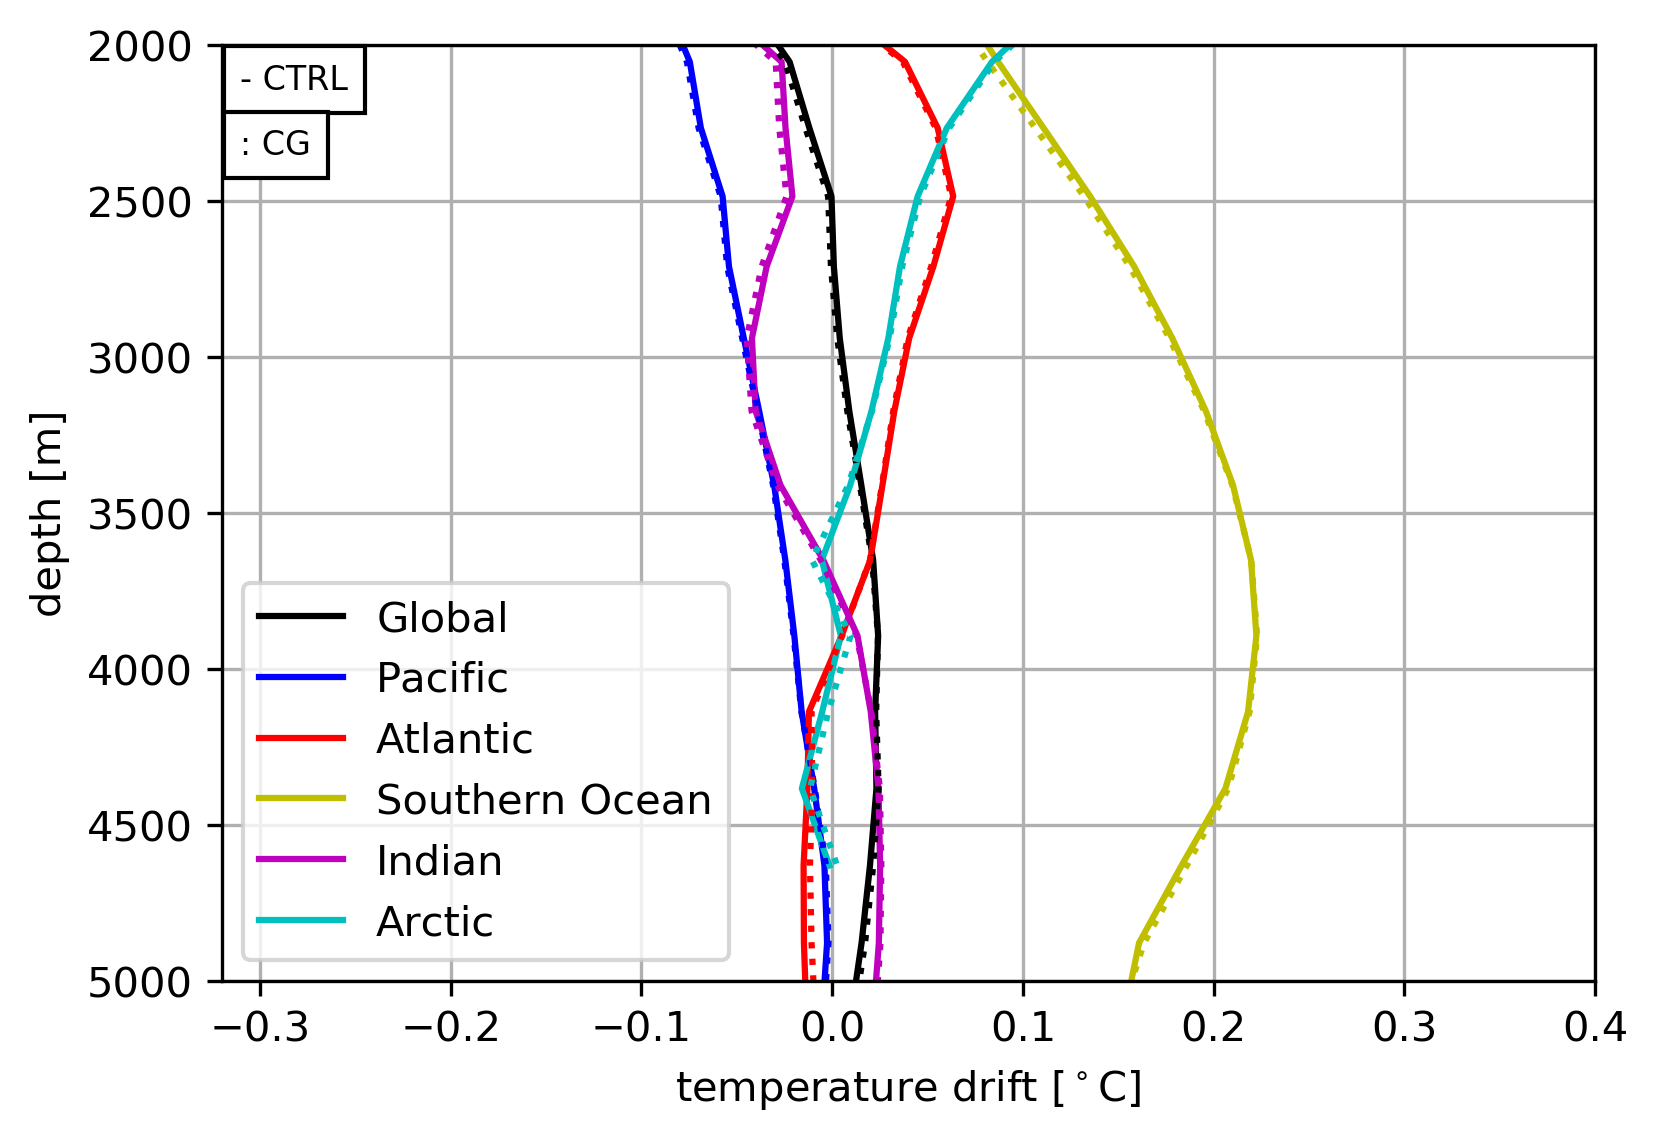

In [73]:
fig = plt.figure(figsize=(convert_cm_to_inch(15), convert_cm_to_inch(10.5)), dpi=300)
gs = gridspec.GridSpec(90, 90)

                            #a
ax1 = plt.subplot(gs[0:90, 0:90])

y = 5 # last 5 years
plt.plot(np.nanmean((T_ave.CTRL_T_glob_mean[-5:,:]   - T_ave.CTRL_T_glob_mean[0,:]),0),deptht,'k',label='Global')
plt.plot(np.nanmean((T_ave.CTRL_T_pac_mean[-5:,:]    - T_ave.CTRL_T_pac_mean[0,:]),0),deptht,'b',label='Pacific')
plt.plot(np.nanmean((T_ave.CTRL_T_atl_mean[-5:,:]    - T_ave.CTRL_T_atl_mean[0,:]),0),deptht,'r',label='Atlantic')
plt.plot(np.nanmean((T_ave.CTRL_T_SO_mean[-5:,:]     - T_ave.CTRL_T_SO_mean[0,:]),0),deptht,'y',label='Southern Ocean')
plt.plot(np.nanmean((T_ave.CTRL_T_ind_mean[-5:,:]    - T_ave.CTRL_T_ind_mean[0,:]),0),deptht,'m',label='Indian')
plt.plot(np.nanmean((T_ave.CTRL_T_arctic_mean[-5:,:] - T_ave.CTRL_T_arctic_mean[0,:]),0),deptht,'c',label='Arctic')
# plt.plot(np.nanmean((T_ave.CG_T_ind_mean[-5:,:]-T_ave.CTRL_T_ind_mean[0,:]),0),deptht)

plt.legend()
plt.plot(np.nanmean((T_ave.CG_T_glob_mean[-5:,:]   - T_ave.CTRL_T_glob_mean[0,:]),0),deptht,':k',label='Global')
plt.plot(np.nanmean((T_ave.CG_T_pac_mean[-5:,:]    - T_ave.CTRL_T_pac_mean[0,:]),0),deptht,':b',label='Pacific')
plt.plot(np.nanmean((T_ave.CG_T_atl_mean[-5:,:]    - T_ave.CTRL_T_atl_mean[0,:]),0),deptht,':r',label='Atlantic')
plt.plot(np.nanmean((T_ave.CG_T_SO_mean[-5:,:]     - T_ave.CTRL_T_SO_mean[0,:]),0),deptht,':y',label='Southern Ocean')
plt.plot(np.nanmean((T_ave.CG_T_ind_mean[-5:,:]    - T_ave.CTRL_T_ind_mean[0,:]),0),deptht,':m',label='Indian')
plt.plot(np.nanmean((T_ave.CG_T_arctic_mean[-5:,:] - T_ave.CTRL_T_arctic_mean[0,:]),0),deptht,':c',label='Arctic')
plt.gca().invert_yaxis()
plt.ylim(5000,2000)
plt.xlim(-0.32,0.4)
plt.grid()
plt.xlabel(r'temperature drift [$^\circ$C]')
plt.ylabel(r'depth [m]')

i=0.0123
j=0.963
plt.text(i+0.001,j,'- CTRL',ha='left',va='center',transform=ax1.transAxes,bbox={'facecolor':'white'},fontsize=8)
plt.text(i+0.001,j-0.07,': CG',ha='left',va='center',transform=ax1.transAxes,bbox={'facecolor':'white'},fontsize=8)

plt.savefig('fig?_tempdrift_vertical+CG__below2000.png',dpi=300, transparent=True)

In [16]:
!conda list

# packages in environment at /gpfs/fs6/home-geomar/smomw122/TM/software/miniconda3_20180110/envs/py2_std:
#
alabaster                 0.7.10                   py27_1    conda-forge
anaconda-client           1.6.5                      py_0    conda-forge
aospy                     0.2                      py27_0    conda-forge
asn1crypto                0.22.0                   py27_0    conda-forge
astroid                   1.5.3                    py27_0    conda-forge
babel                     2.5.1                    py27_0    conda-forge
backports                 1.0                      py27_1    conda-forge
backports.functools_lru_cache 1.4                      py27_1    conda-forge
backports.shutil_get_terminal_size 1.0.0                      py_3    conda-forge
backports_abc             0.5                      py27_0    conda-forge
basemap                   1.1.0                    py27_3    conda-forge
basemap-data-hires        1.1.0                         0    conda-forge
big